In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: Phishing_Legitimate_full.csv  


In [2]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ## 2. Data Loading and EDA
# 피싱 데이터셋을 로드하고 기본적인 정보를 확인합니다.
try:
    df = pd.read_csv("/content/Phishing_Legitimate_full.csv")
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'Phishing_Legitimate_full.csv' not found. Please check the file path.")
    df = pd.DataFrame()

Dataset loaded successfully.
Dataset shape: (10000, 50)


In [4]:
# 데이터의 첫 5행과 정보 확인
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   id  NumDots  SubdomainLevel  PathLevel  UrlLength  NumDash  \
0   1        3               1          5         72        0   
1   2        3               1          3        144        0   
2   3        3               1          2         58        0   
3   4        3               1          6         79        1   
4   5        3               0          4         46        0   

   NumDashInHostname  AtSymbol  TildeSymbol  NumUnderscore  ...  \
0                  0         0            0              0  ...   
1                  0         0            0              2  ...   
2                  0         0            0              0  ...   
3                  0         0            0              0  ...   
4                  0         0            0              0  ...   

   IframeOrFrame  MissingTitle  ImagesOnlyInForm  SubdomainLevelRT  \
0              0             0                 1                 1   
1              0             0      

In [5]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents         

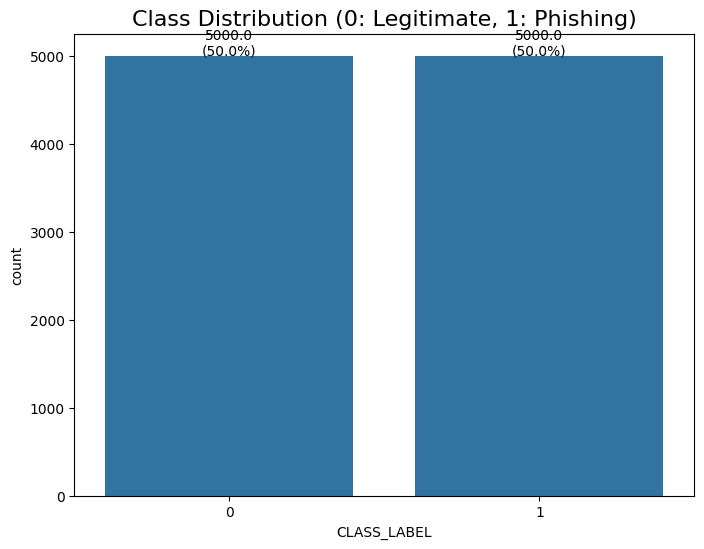

In [7]:
# 클래스 분포 확인 (0: 정상, 1: 피싱)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CLASS_LABEL', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Phishing)', fontsize=16)
class_counts = df['CLASS_LABEL'].value_counts()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.show()

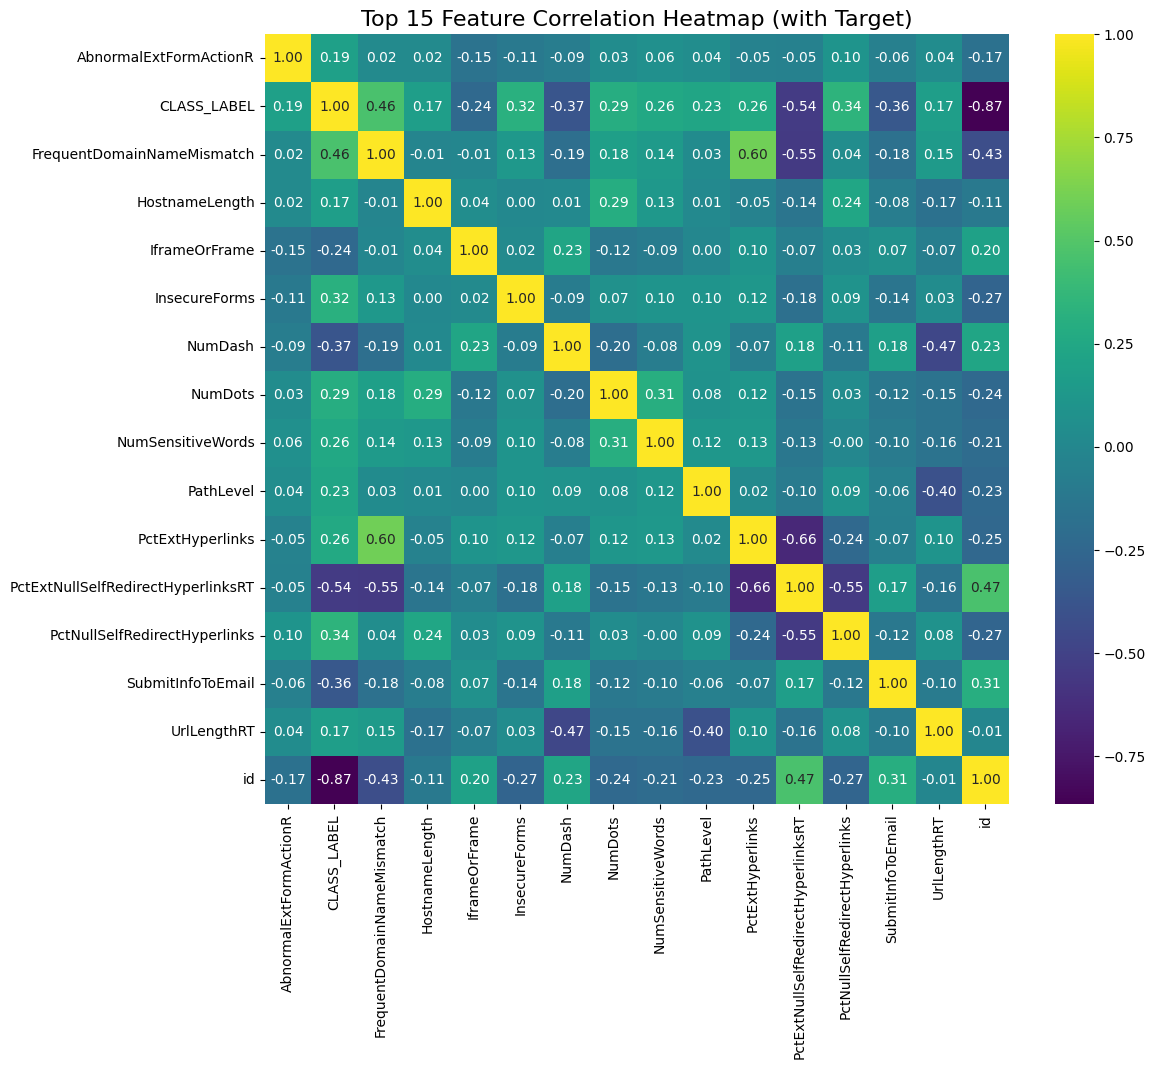

In [13]:
# 특성 간 상관관계 히트맵 (상관계수가 높은 상위 15개 특성만 표시)
plt.figure(figsize=(12, 10))
corr = df.corr()

# 수정된 부분: .index를 사용하여 특성 이름만 추출
top_corr_features = np.abs(corr["CLASS_LABEL"]).sort_values(ascending=False)[1:16].index

# CLASS_LABEL도 함께 히트맵에 포함하여 시각화
top_corr_df = df[top_corr_features.union(['CLASS_LABEL'])]
sns.heatmap(top_corr_df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Top 15 Feature Correlation Heatmap (with Target)', fontsize=16)
plt.show()

In [14]:
# ## 3. Data Preprocessing
# 모델 학습을 위해 데이터를 준비합니다.
X = df.drop('CLASS_LABEL', axis=1)
y = df['CLASS_LABEL']

# 훈련/테스트 데이터 분할 (클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 수치형 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (8000, 49)
Test data shape: (2000, 49)


In [15]:
# ## 4. Model Training and Comparison
# 여러 분류 모델을 학습시키고 성능을 비교합니다.
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost (Base)": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)['1'] # '1'은 피싱 클래스

    results[name] = {
        'Accuracy': accuracy,
        'Precision': report['precision'],
        'Recall': report['recall'],
        'F1-Score': report['f1-score']
    }

results_df = pd.DataFrame(results).T
print("\n--- Model Performance Comparison ---")
print(results_df)


--- Training Logistic Regression ---

--- Training Random Forest ---

--- Training XGBoost (Base) ---

--- Model Performance Comparison ---
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression     0.999      0.999   0.999     0.999
Random Forest           1.000      1.000   1.000     1.000
XGBoost (Base)          1.000      1.000   1.000     1.000


In [16]:
# ## 5. Hyperparameter Tuning (XGBoost)
# 가장 성능이 좋았던 XGBoost 모델의 성능을 최적화합니다.
if not df.empty:
    print("\n--- Hyperparameter Tuning for XGBoost ---")

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'subsample': [0.7, 0.8, 0.9, 1.0]
    }

    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=20, # 20개의 조합을 랜덤하게 테스트
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    print("\nBest parameters found: ", random_search.best_params_)

    best_xgb = random_search.best_estimator_

    # 튜닝된 모델의 성능을 결과에 추가
    y_pred_tuned = best_xgb.predict(X_test)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)['1']

    results['XGBoost (Tuned)'] = {
        'Accuracy': accuracy_tuned,
        'Precision': report_tuned['precision'],
        'Recall': report_tuned['recall'],
        'F1-Score': report_tuned['f1-score']
    }


--- Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}



--- Final Model Performance Comparison ---
                     Accuracy  Precision  Recall  F1-Score
Random Forest           1.000      1.000   1.000     1.000
XGBoost (Base)          1.000      1.000   1.000     1.000
XGBoost (Tuned)         1.000      1.000   1.000     1.000
Logistic Regression     0.999      0.999   0.999     0.999

--- Detailed Analysis of Best Model: XGBoost (Tuned) ---


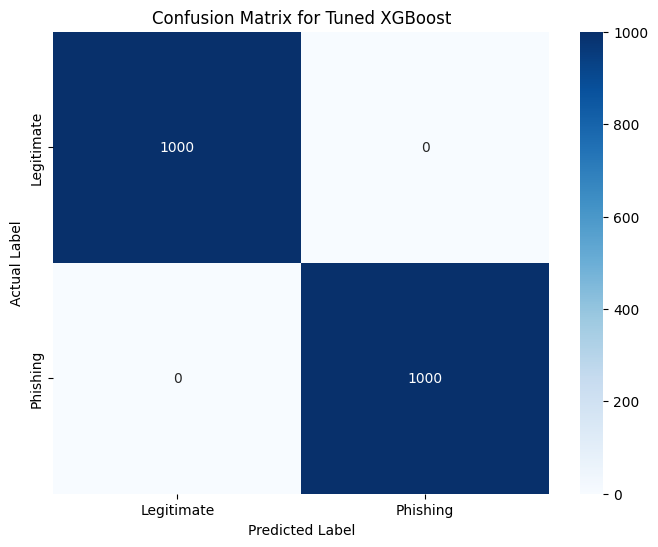


Classification Report for Tuned XGBoost
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      1000
    Phishing       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



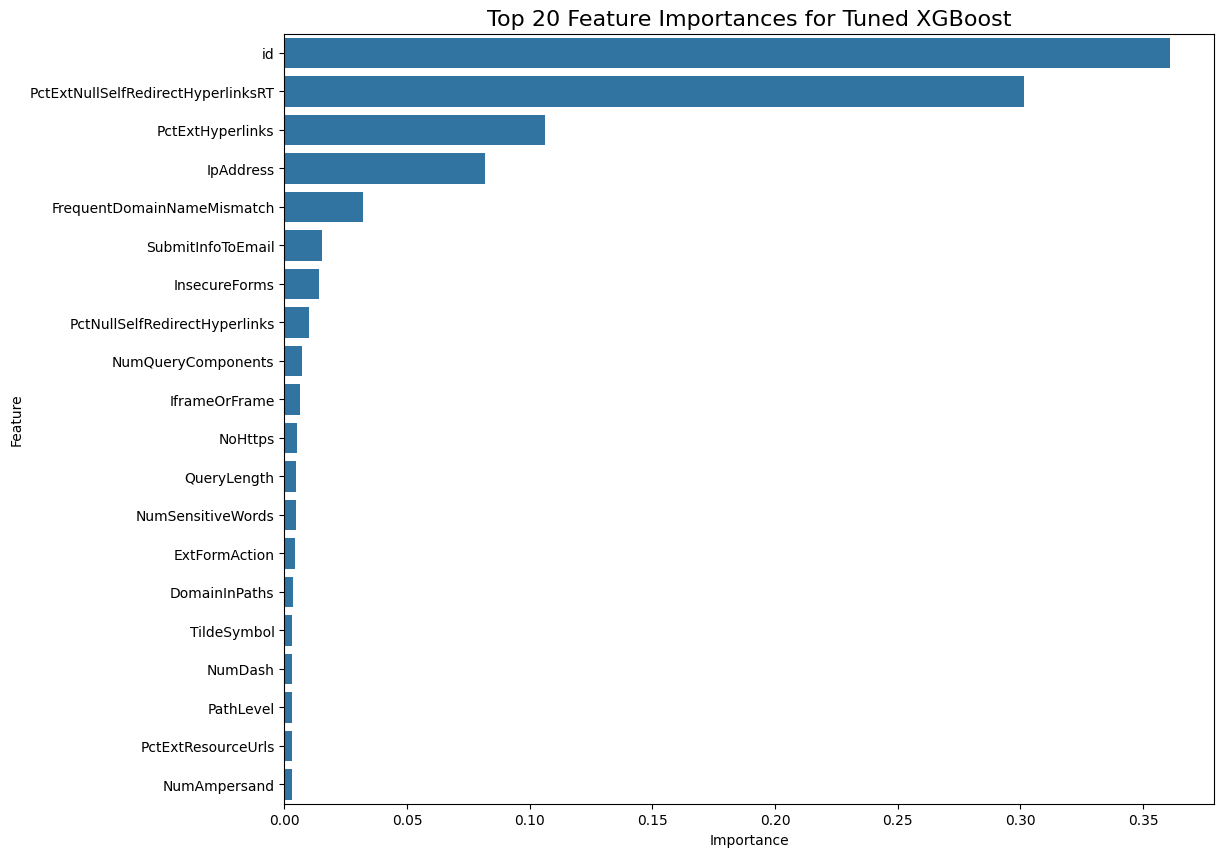

In [17]:
# ## 6. Final Evaluation and Analysis
if not df.empty:
    # 최종 성능 비교표
    final_results_df = pd.DataFrame(results).T
    print("\n--- Final Model Performance Comparison ---")
    print(final_results_df.sort_values(by='F1-Score', ascending=False))

    # 최종 모델(Tuned XGBoost)에 대한 상세 분석
    print(f"\n--- Detailed Analysis of Best Model: XGBoost (Tuned) ---")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_tuned)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix for Tuned XGBoost')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print('\nClassification Report for Tuned XGBoost')
    print(classification_report(y_test, y_pred_tuned, target_names=['Legitimate', 'Phishing']))

    # Feature Importance
    feature_importances = best_xgb.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20)) # 상위 20개 특성
    plt.title('Top 20 Feature Importances for Tuned XGBoost', fontsize=16)
    plt.show()